In [315]:
import pandas as pd
import numpy as np
import scipy.io as io
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
%matplotlib inline
plt.rcParams.update({'legend.fontsize': 30, 'axes.labelsize' : 15, 'figure.figsize': (15, 10), 'font.size': 13})

In [207]:
io.loadmat('sub3_comp.mat')

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Jul 23 16:49:39 2008',
 '__version__': '1.0',
 '__globals__': [],
 'train_data': array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
        [  842,  1850,  1461, ...,  -897,  -385, -1558],
        [  582,  1912,  1505, ...,  -549,  -391, -1414],
        ...,
        [  309,  2077,   492, ...,   402,   852,  1240],
        [   45,  1931,   415, ...,   336,   642,   950],
        [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16),
 'test_data': array([[  167,  2488,   751, ...,  1254,   892,  1689],
        [ -133,  2371,   532, ...,  1241,   486,  1683],
        [ -714,  1957,    23, ...,   789,  -332,  1241],
        ...,
        [ -311,  1045, -1718, ..., -3047,   888,   981],
        [ -487,  1020, -1896, ..., -3125,   862,   941],
        [ -600,   913, -1980, ..., -3232,   812,   984]]),
 'train_dg': array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
        [-0.41384039

In [281]:
X = io.loadmat('sub3_comp.mat')['train_data']
Y = io.loadmat('sub3_comp.mat')['train_dg']
new_X = []
new_Y = []
for i in range(Y.shape[0]):
    if (Y[i][4] < 0.1):
        new_X.append(X[i])
        new_Y.append(Y[i])  
new_X = np.array(new_X)
new_Y = np.array(new_Y)

In [282]:
new_X.shape

(315040, 64)

In [284]:
class NEPALS:
    def __init__(self, k):
        self.k = k
        self.scaleX = preprocessing.StandardScaler()
        self.scaleY = preprocessing.StandardScaler()
    def fit(self, X, Y):
        self.scaleX.fit(X)
        self.scaleY.fit(Y)
        X = self.scaleX.transform(X)
        Y = self.scaleY.transform(Y)
        A = X.T @ Y
        M = X.T @ X
        C = np.identity(X.shape[1])
        W = []
        Q = []
        for _ in range(self.k):
            q = NEPALS.dominance_eigen(self, A.T @ A)
            w = C @ A @ np.vstack(q)
            w = w / np.linalg.norm(w)
            W.append(w.flatten())
            p = M @ w
            c = w.T @ M @ w
            p = p / c
            q = A.T @ w / c
            Q.append(q.flatten())
            A = A - c * p @ q.T
            M = M - c * p @ p.T
            C = C - w @ p.T
        self.B = np.vstack(W).T @ np.vstack(Q)
    def predict(self, X):
        X = self.scaleX.transform(X)
        return self.scaleY.inverse_transform(X @ self.B)
    def dominance_eigen(self, D):
        w, v = np.linalg.eig(D)
        return v[np.argmax(w)]

In [289]:
e = []
for i in range(1, 65):
    est = PLSRegression(n_components=i)
    est.fit(new_X, new_Y)
    e.append(np.mean(np.abs(new_Y - est.predict(new_X))))

KeyboardInterrupt: 

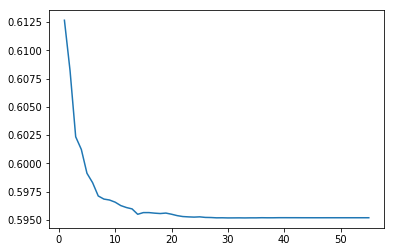

In [291]:
plt.plot(range(1, 56), e)

In [292]:
def validation_parts(n, k):
    total = set(range(0, n))
    res = []
    for i in range(1, k + 1):
        part = np.array(range(((i - 1) * n) // k, (i * n) // k))
        r = total.difference(part)
        res.append([part, np.array(list(r))])
    return res
def validation(est, X, Y, k):
    X = np.array(X)
    Y = np.array(Y)
    errors = []
    for it in validation_parts(X.shape[0], k):
        est.fit(X[it[1]], Y[it[1]])
        Y_pr = est.predict(X[it[0]])
        errors.append(np.mean(np.abs(Y[it[0]] - Y_pr)))
    return np.mean(errors), np.var(errors)

In [293]:
errors = []
errors_div = []
for k in range(1, X.shape[1]):
    error, error_div = validation(NEPALS(k), X, Y, 10)
    errors.append(error)
    errors_div.append(error_div)

(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1726,  -169,   596, ...,  -158,   747, -2135],
       [ 1563,  -360,   301, ...,  -506,   539, -2407],
       [ 2059,    87,   615, ...,     2,   986, -2052],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       [ 0.10585532,  0.19430852,  2.13382484, -0.68621548, -0.34460236],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  309,  2077,   492, ...,   402,   852,  1240],
       [   45,  1931,   415, ...,   336,   642,   950],
       [   68,  2157,   558, ...,   712,   741,  1208]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079],
       [-0.178245  ,  0.22336148, -0.25495768, -0.25018584,  0.02674079]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 1392,  2132,  1811, ...,  -705,   -15, -1290],
       [  842,  1850,  1461, ...,  -897,  -385, -1558],
       [  582,  1912,  1505, ...,  -549,  -391, -1414],
       ...,
       [  -60,  -623,  1062, ..., -2504,  -374, -1309],
       [  -97,  -818,   909, ..., -2757,  -670, -1734],
       [  266,  -730,  1061, ..., -2566,  -572, -1737]], dtype=int16), array([[-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.41384039, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       ...,
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318],
       [-0.23367921, -0.18337996,  0.2128751 ,  2.24379257,  0.33300318]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


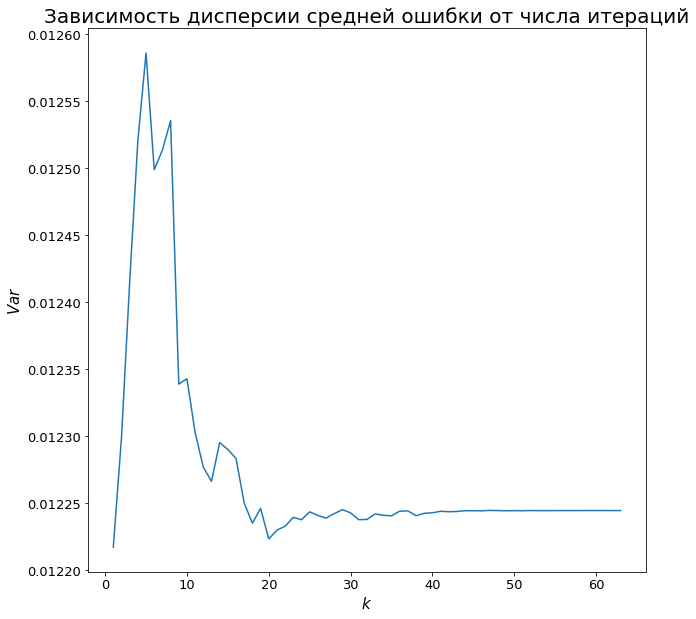

In [330]:
fig, ax = plt.subplots(nrows=1,figsize=(10, 10))
ax.plot(range(1, X.shape[1]), errors_div)
ax.set_title(r'Зависимость дисперсии средней ошибки от числа итераций', {'fontsize': 20}) 
ax.set_ylabel(r'$Var$')
ax.set_xlabel(r'$k$')
plt.savefig('dispersion')

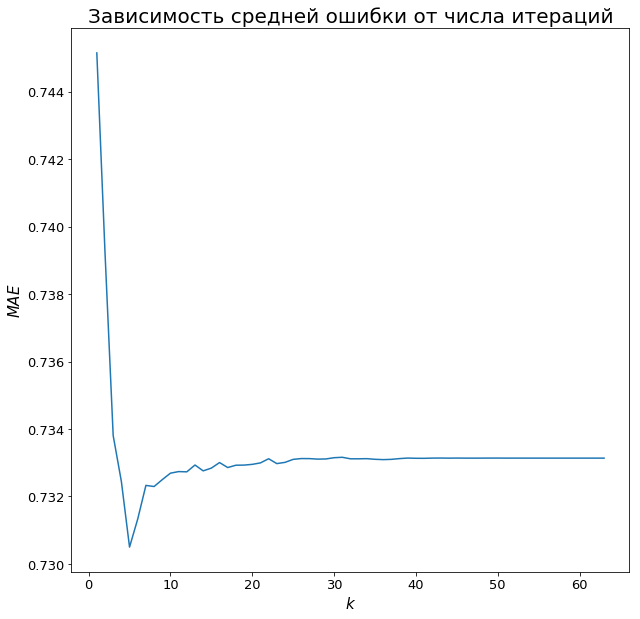

In [331]:
fig, ax = plt.subplots(nrows=1,figsize=(10, 10))
ax.plot(range(1, X.shape[1]), errors)
ax.set_title(r'Зависимость средней ошибки от числа итераций', {'fontsize': 20}) 
ax.set_ylabel(r'$MAE$')
ax.set_xlabel(r'$k$')
plt.savefig('error')

In [321]:
errors_vol = []
errors_div_vol = []
for p in range(40, 91, 10):
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    error, error_div = validation(NEPALS(20), X[indexes[:X.shape[0] * p // 100]], Y[indexes[:X.shape[0] * p // 100]], 10)
    errors_vol.append(error)
    errors_div_vol.append(error_div)

(array([[  839,   841,  1869, ..., -2004,  4459,   260],
       [  -19,  -207,   749, ...,  1313, -2220, -1661],
       [ 1425,  -704,   352, ...,  3256,  1045,  -363],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-1.05826307,  2.69286308,  0.36881936, -0.20019518, -0.43648108],
       [ 3.86152299, -0.81673449, -0.98506035, -1.59437911, -0.58961227],
       [-0.65636506, -0.75281797, -1.39146054, -1.06392268, -0.45562248],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-0.13666935,  1.25764686,  2.5780297 ,  0.56077373, -0.14170353],
       [-0.24060849,  0.19430852,  0.61218691,  2.46041876,  0.39808394],
       [-0.09509369, -0.12527404, -0.50541361, -0.15575904,  0.08033671],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-0.13666935,  1.25764686,  2.5780297 ,  0.56077373, -0.14170353],
       [-0.24060849,  0.19430852,  0.61218691,  2.46041876,  0.39808394],
       [-0.09509369, -0.12527404, -0.50541361, -0.15575904,  0.08033671],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-0.13666935,  1.25764686,  2.5780297 ,  0.56077373, -0.14170353],
       [-0.24060849,  0.19430852,  0.61218691,  2.46041876,  0.39808394],
       [-0.09509369, -0.12527404, -0.50541361, -0.15575904,  0.08033671],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-0.13666935,  1.25764686,  2.5780297 ,  0.56077373, -0.14170353],
       [-0.24060849,  0.19430852,  0.61218691,  2.46041876,  0.39808394],
       [-0.09509369, -0.12527404, -0.50541361, -0.15575904,  0.08033671],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-0.13666935,  1.25764686,  2.5780297 ,  0.56077373, -0.14170353],
       [-0.24060849,  0.19430852,  0.61218691,  2.46041876,  0.39808394],
       [-0.09509369, -0.12527404, -0.50541361, -0.15575904,  0.08033671],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-0.13666935,  1.25764686,  2.5780297 ,  0.56077373, -0.14170353],
       [-0.24060849,  0.19430852,  0.61218691,  2.46041876,  0.39808394],
       [-0.09509369, -0.12527404, -0.50541361, -0.15575904,  0.08033671],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-0.13666935,  1.25764686,  2.5780297 ,  0.56077373, -0.14170353],
       [-0.24060849,  0.19430852,  0.61218691,  2.46041876,  0.39808394],
       [-0.09509369, -0.12527404, -0.50541361, -0.15575904,  0.08033671],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -535,  1297, -2551, ...,  1900, -1076,  -850],
       [-4831,  -759,  -740, ...,   326,  6011,   841],
       [  -13,    90,  -230, ..., -1114,  -301,  1055]], dtype=int16), array([[-0.13666935,  1.25764686,  2.5780297 ,  0.56077373, -0.14170353],
       [-0.24060849,  0.19430852,  0.61218691,  2.46041876,  0.39808394],
       [-0.09509369, -0.12527404, -0.50541361, -0.15575904,  0.08033671],
       ...,
       [-0.48313315, -0.68890146, -0.98033476, -0.7723105 , -0.51687496],
       [-0.01887165,  0.99617022,  2.42444823,  0.57466003, -0.11490557],
       [-0.09509369,  0.51970167, -0.38727402,  1.40783767,  2.56871864]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1955, -1902,  -604, ..., -3518,  -573,  2042],
       [ 2013, -1159,   270, ...,  4925,   648, -1590],
       [  135,   -61,    13, ..., -1975,  2998,  -392],
       ...,
       [ -426,  -602, -2219, ..., -3471,   121,  1857],
       [  387,  1054,  2273, ...,  1369,  -704,  3429],
       [ 1732,   931,   646, ...,  2707,  5403, -2422]], dtype=int16), array([[-1.36669347e-01,  1.25764686e+00,  2.57802970e+00,
         5.60773732e-01, -1.41703525e-01],
       [-2.40608489e-01,  1.94308520e-01,  6.12186913e-01,
         2.46041876e+00,  3.98083941e-01],
       [-9.50936902e-02, -1.25274039e-01, -5.05413611e-01,
        -1.55759043e-01,  8.03367089e-02],
       ...,
       [-1.78245004e-01,  2.55898471e-03,  2.17600681e-01,
         2.68815398e+00,  6.96689773e-01],
       [-5.03920983e-01, -1.54326999e-01, -1.25004131e-01,
         6.66309567e-01,  2.84818308e+00],
       [-3.79194012e-01, -6.88901462e-01, -2.69134431e-01,
        -7.02879030e-01, -5.20703236e-01]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ -345,  -116,  1615, ...,  4852,  2439,   662],
       [ 2960,  3450,  2760, ...,   872,    98,  -166],
       [-1006,   426,   971, ..., -2390,  1484,  -755],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.10895224,  2.99501386,  0.48223336, -0.49180736, -0.28334988],
       [ 0.32066288, -0.57850021, -0.38727402, -0.72787436, -0.46710732],
       [-0.31683053, -0.69471205, -1.16935811, -0.86951456, -0.36374376],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -672,  -563,   310, ..., -1660, -2612, -2417],
       [-1204,   427, -1380, ...,  3863, -1144, -1495],
       [ -976,   -57, -1862, ..., -2045,  -709,  3106]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.16438645, -0.59593199,  0.43497753,  0.84127687, -0.40585484],
       [-0.30990125,  0.62429233,  0.67834508,  2.19380192,  3.77462681],
       [-0.24060849,  0.39767924,  0.08292155,  1.77165858, -0.39819828]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[  284,   425,   516, ...,  4372,  3169, -1322],
       [ 2744,   891,  3745, ...,  -718, -2524,  2513],
       [-1234,   410,   512, ...,   351,  -824, -3636],
       ...,
       [ -371,   -62,  -405, ...,  1018,  2346,   808],
       [ 1462,   938,  -787, ...,  1303,  -310,   333],
       [ 1796,  -728,  1874, ..., -2260,   128,  3659]], dtype=int16), array([[-0.95432393,  1.26926804, -1.25205582, -1.78045545, -0.68914755],
       [-0.25446704,  0.96130666,  0.16561926,  2.67982221,  0.57418482],
       [-0.54549664,  1.95491789, -0.12264134, -0.53902076, -0.42882452],
       ...,
       [-0.01887165,  0.03161194,  0.42552636,  2.58539541,  0.61246762],
       [-0.5870723 , -0.21824351, -0.52904153, -1.07503171, -0.490077  ],
       [ 2.89835361, -0.36350831, -0.69443696, -0.16409082, -0.48624872]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1486,   -81,  -421, ...,  -157,  -178,   323],
       [ -651, -1936,  -203, ...,   914,  -959, -2088],
       [ -279,  -805,   410, ...,  3828,  2274,   712],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[-0.26139632,  3.6167472 ,  0.77994513,  0.13863039, -0.21826912],
       [-0.27525487, -0.6598485 ,  0.08055876,  0.29415689, -0.4135114 ],
       [-0.83652624,  2.08275092, -0.01159012, -0.32517183, -0.40202656],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -145,     0,  -926, ...,   826,  1768, -1893],
       [  363,   196, -3396, ...,  3612, -3158, -2165],
       [ 3609,  -280,   196, ...,   470, -1613, -2613]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [-0.72565782, -0.72957561, -0.73933   , -0.83618745, -0.55898603],
       [-0.2960427 , -0.82254508, -0.55503224, -0.73065162, -0.5283598 ],
       [-0.82959696,  0.68239825, -0.55266945, -0.56401609, -0.46327904]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1566,   578,  -152, ...,  2564,  1825,  -248],
       [ 1331,   502,    76, ..., -2869, -2693, -3043],
       [  510,    14,  -247, ...,   258,  1653, -3800],
       ...,
       [ -588,  -986, -1002, ...,  -575,  -562,   151],
       [-1889,  -413, -1107, ...,  -542,  -648,  -730],
       [  110,  2832,  -469, ...,  3048, -2268,    58]], dtype=int16), array([[ 0.1682188 , -0.79930271, -0.24550651, -0.83896471, -0.59726883],
       [-0.37226474, -0.34026594, -0.83147888,  0.75795911,  1.89876966],
       [ 0.17514808, -0.83416626,  0.02857734, -0.55568431, -0.63555163],
       ...,
       [ 0.33452143, -0.5145837 , -0.56212061,  1.81331746, -0.01154201],
       [-0.43462822,  0.77536772,  0.44442869,  0.98291707,  3.08170815],
       [-0.27525487, -0.00325161, -0.60701366,  1.01346692,  2.22800173]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[   61,  2333,   981, ..., -3262,   741,  1318],
       [ 2277,   529,   582, ...,  2343, -2552, -1077],
       [ 2771,   387,  1282, ...,  -421,  3111,  1074],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.78109203, -0.68890146, -2.65082857, -1.80545078, -0.61641023],
       [-0.44848677,  0.31633095, -0.37073448,  1.28841554,  2.67973876],
       [-0.21289138,  2.54178769,  0.79884747,  0.16084846, -0.34460236],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [-1703,   452, -1346, ..., -5031,  4864,   731],
       [   86,     2,  2649, ...,  1211,  4205,  5773],
       [-2204, -3160, -1363, ...,  3690,   -43,  -594]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.84345551, -0.61917436, -0.69443696, -1.06669993, -0.53218808],
       [-0.71179927, -0.52039429, -0.63536716, -1.09447252, -0.53601636],
       [-0.33068908,  0.69401943, -0.45579498,  1.70778162,  2.72184984]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1979,   331, -1660, ...,   942,  -564, -5475],
       [  156,  1084,  1722, ..., -2450,   202,  -655],
       [-2535,   354,  -606, ...,  -353,  -154,  1202],
       ...,
       [ 1245,  1281,  1798, ..., -1753,  3532,  4617],
       [ 1766,  -426, -4500, ..., -1709, -1054,  -894],
       [  135, -1511, -3331, ..., -3594,   787, -4023]], dtype=int16), array([[-0.42769895, -0.93294633, -0.87873472, -0.56957061, -0.55132947],
       [-0.82959696,  0.2814674 , -0.31166468, -1.56660652, -0.25655192],
       [-0.39998184, -0.72957561, -0.54321828, -1.10002704, -0.62406679],
       ...,
       [-0.09509369,  0.18849793,  2.33938772,  0.73574104, -0.34460236],
       [ 0.27215795, -0.63079554, -0.55975782, -0.13354097, -0.298663  ],
       [-0.47620388,  0.04904372, -0.54558107, -0.67232918, -0.45562248]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ -525, -2069,   -24, ..., -1149,  3064,  3114],
       [-1571,  1065, -1885, ...,  -106, -1448,  -389],
       [-1806,  2311,   248, ...,   792, -4115,  2517],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[-0.13666935,  0.21755089,  1.09183365,  2.27156516,  0.13776091],
       [-0.37226474, -0.42161423, -1.10083715, -0.84174197, -0.20678428],
       [-0.25446704, -0.27634943, -0.40145077, -0.05300047, -0.2412388 ],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[ 2.13613323, -0.19500114, -0.11319017, -0.05300047, -0.55898603],
       [ 0.25829939, -0.5145837 , -0.37782285,  2.17158384, -0.14170353],
       [-0.30990125,  3.05311978,  0.2979356 ,  0.05253537, -0.32163268],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[ 2.13613323, -0.19500114, -0.11319017, -0.05300047, -0.55898603],
       [ 0.25829939, -0.5145837 , -0.37782285,  2.17158384, -0.14170353],
       [-0.30990125,  3.05311978,  0.2979356 ,  0.05253537, -0.32163268],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[ 2.13613323, -0.19500114, -0.11319017, -0.05300047, -0.55898603],
       [ 0.25829939, -0.5145837 , -0.37782285,  2.17158384, -0.14170353],
       [-0.30990125,  3.05311978,  0.2979356 ,  0.05253537, -0.32163268],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[ 2.13613323, -0.19500114, -0.11319017, -0.05300047, -0.55898603],
       [ 0.25829939, -0.5145837 , -0.37782285,  2.17158384, -0.14170353],
       [-0.30990125,  3.05311978,  0.2979356 ,  0.05253537, -0.32163268],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[ 2.13613323, -0.19500114, -0.11319017, -0.05300047, -0.55898603],
       [ 0.25829939, -0.5145837 , -0.37782285,  2.17158384, -0.14170353],
       [-0.30990125,  3.05311978,  0.2979356 ,  0.05253537, -0.32163268],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[ 2.13613323, -0.19500114, -0.11319017, -0.05300047, -0.55898603],
       [ 0.25829939, -0.5145837 , -0.37782285,  2.17158384, -0.14170353],
       [-0.30990125,  3.05311978,  0.2979356 ,  0.05253537, -0.32163268],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[ 2.13613323, -0.19500114, -0.11319017, -0.05300047, -0.55898603],
       [ 0.25829939, -0.5145837 , -0.37782285,  2.17158384, -0.14170353],
       [-0.30990125,  3.05311978,  0.2979356 ,  0.05253537, -0.32163268],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [  992,  -309,   426, ...,  5390,  1754,   329],
       [  628,  1547,  1527, ...,  2955, -3631,   959],
       [-2260,  -964, -2177, ..., -2043,   540,  -548]], dtype=int16), array([[ 2.13613323, -0.19500114, -0.11319017, -0.05300047, -0.55898603],
       [ 0.25829939, -0.5145837 , -0.37782285,  2.17158384, -0.14170353],
       [-0.30990125,  3.05311978,  0.2979356 ,  0.05253537, -0.32163268],
       ...,
       [-0.67022361, -0.5901214 , -0.48414849, -0.71676532, -0.55515775],
       [-0.91274828,  2.49530295,  0.14907972, -0.21408148, -0.42116796],
       [ 0.08506749,  0.95549607,  2.62292274,  1.48837818,  0.01908423]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1872,  -779, -2845, ...,  2307, -3106, -3127],
       [ 2388,  -972,  1270, ..., -3016,  -793,  1415],
       [ 3336,  2058,  -596, ...,   291, -2734, -1723],
       ...,
       [ -177, -2206,  -360, ...,  -374, -1385,  1269],
       [   82,  1968,  -540, ...,  3315, -1576,  2965],
       [ -395,  1138,  -480, ..., -2334,  4107,  1668]], dtype=int16), array([[ 2.13613323e+00, -1.95001143e-01, -1.13190172e-01,
        -5.30004666e-02, -5.58986035e-01],
       [ 2.58299393e-01, -5.14583703e-01, -3.77822854e-01,
         2.17158384e+00, -1.41703525e-01],
       [-3.09901251e-01,  3.05311978e+00,  2.97935603e-01,
         5.25353684e-02, -3.21632681e-01],
       ...,
       [-1.71315728e-01, -6.01742583e-01, -7.41692792e-01,
        -1.39095490e-01, -4.24996238e-01],
       [ 2.84291940e+00,  3.16119447e-02,  2.58662695e-03,
        -6.25115783e-01, -5.85783994e-01],
       [ 2.62118256e+00, -2.12432919e-01, -4.23064174e-02,
        -8.56432559e-03, -5.51329475e-01]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[ 2807,    51,  1017, ..., -1840,  2991,  2336],
       [ 2512, -1428,   284, ..., -3736, -5896,  4063],
       [ 1526,  -236,   440, ...,  -831, -1238, -1836],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[-0.18517428, -0.25891765,  0.78230792,  1.86608538, -0.1646732 ],
       [-0.39998184, -0.67728028, -0.17698555, -0.1252092 , -0.48242044],
       [-0.73951637, -0.61336377, -0.71806487, -0.8195239 , -0.56281431],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [ -422,   567,  1544, ...,  1366, -3858,   512],
       [  784,  -165,   -98, ..., -1764, -1474, -1941],
       [ -877, -1881,  1368, ..., -1215,  -387,  4941]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.40691112, -0.76443916, -2.61538669, -1.89710032, -0.54750119],
       [-0.59400157,  0.6475347 ,  2.41027148, -0.21408148, -0.38288516],
       [-0.4415575 , -0.05554694,  2.07948062, -0.11965468, -0.42116796]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([[-1457,   -61, -3359, ..., -1818, -2329,  2507],
       [ -754, -1657,  1273, ...,  2118, -3055, -1215],
       [ 1966,  1529, -1955, ...,  2568,   208,  2272],
       ...,
       [-3016, -2940, -2861, ...,  3520, -2391,  3051],
       [ -641, -3537, -2425, ..., -3197,  -135, -4777],
       [  112,  1526,   276, ...,  -399,   749, -2811]], dtype=int16), array([[ 2.17770889, -0.62498495, -1.06775806, -0.75842421, -0.53218808],
       [ 3.65364471, -0.84578745, -0.14626926, -0.61400675, -0.61641023],
       [-0.39998184,  0.43254279,  1.67544323, -0.85562826, -0.14553181],
       ...,
       [-0.64943578, -0.13108463, -0.41562752, -0.45848025, -0.4326528 ],
       [-0.37226474, -0.81092389, -1.01105106, -1.4805115 , -0.61641023],
       [ 0.05735039,  0.16525556,  0.01912617,  2.01050283,  0.55121514]]))


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


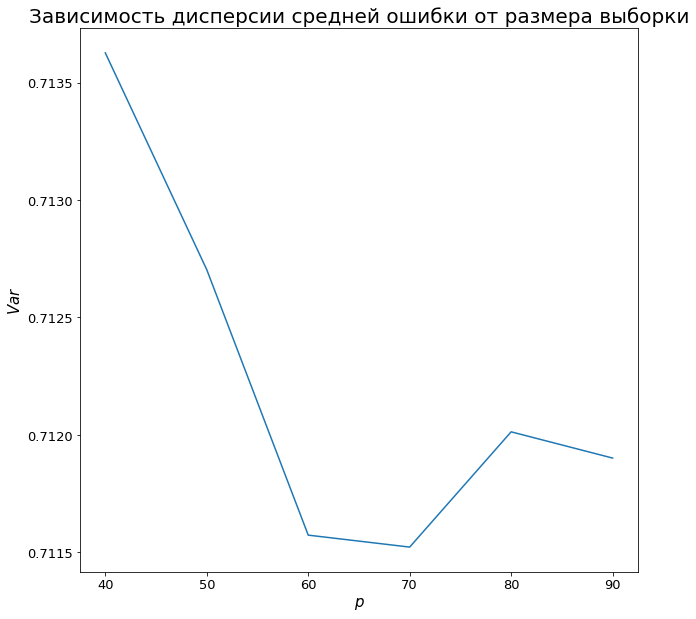

In [328]:
fig, ax = plt.subplots(nrows=1,figsize=(10, 10))
ax.plot(range(40, 91, 10), errors_vol)
ax.set_title(r'Зависимость дисперсии средней ошибки от размера выборки', {'fontsize': 20}) 
ax.set_ylabel(r'$Var$')
ax.set_xlabel(r'$p%$')
plt.savefig('dispersion vol')

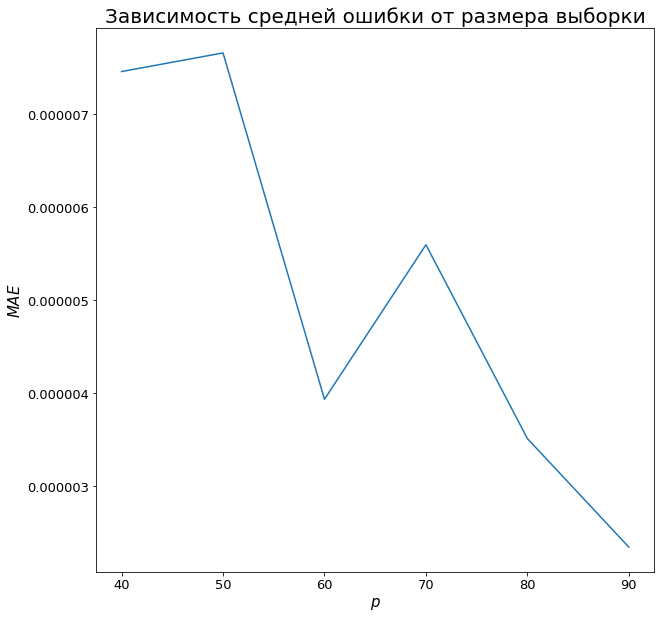

In [329]:
fig, ax = plt.subplots(nrows=1,figsize=(10, 10))
ax.plot(range(40, 91, 10), errors_div_vol)
ax.set_title(r'Зависимость средней ошибки от размера выборки', {'fontsize': 20}) 
ax.set_ylabel(r'$MAE$')
ax.set_xlabel(r'$p%$')
plt.savefig('error vol')

In [267]:
np.vstack([[1], [3]])

array([[1],
       [3]])